# Identifying Enron Persons of Interest

## Project Overview

The investigation of the accounting fraud discovered in 2002 within the Enron Corporation has resulted a vast amount of otherwise confidential company information being made public.

This project attempts to predict who persons of interest (POI's) are within Enron in relation to the accounting fraud that occurred. The data I am working with contains financial information and email pattern information of potential persons of interest. I will be using machine learning in order to predict whether an individual could be a person of interest based on their financial and email data.

The project will involve trying a variety of different machine learning algorithms and using evaluation techniques to identify the most effective algorithm.

I'll begin by loading the dictionary which contains the dataset.

In [188]:
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

from tester import dump_classifier_and_data, test_classifier

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)



## Data Exploration

Now that the dataset has been loaded, I need to get an overview of the data, and to identify any potential outliers.

In [189]:
# How many data points (people)?
print "Number of data points:", len(data_dict)

# For each person, how many features are available?
print "Number of features:", len(data_dict["SKILLING JEFFREY K"])

# How many POIs are there in the E+F dataset?
print "Number of POI's in dataset:", len(dict((key, value) for key, value in data_dict.items() 
                                              if value["poi"] == True))



Number of data points: 146
Number of features: 21
Number of POI's in dataset: 18


As stated above, of the 146 people in the data set, only 18 have been identified as being a person of interest.

I will take a closer look at the data by loading it into a dataframe.

In [191]:
import numpy as np
import pandas as pd

def dataframing(data_dict):

    df = pd.DataFrame(data_dict)
    df = df.T
    #df = df.convert_objects(convert_numeric=True)
    df = df.apply(pd.to_numeric, errors='coerce')

    return df

df = dataframing(data_dict)
df.head()


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,NaN,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,NaN,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,NaN,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


Just from the summary data above, it is apparent that there is a lot of missing data in this dataset. Lets get some exact numbers on this:

In [192]:
df.isnull().sum() 

bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                146
exercised_stock_options       44
expenses                      51
from_messages                 60
from_poi_to_this_person       60
from_this_person_to_poi       60
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       60
to_messages                   60
total_payments                21
total_stock_value             20
dtype: int64

As above, deferral_payments, director_fees, loan_advances, restricted_stock_deferred, deferred_income, and long_term_incentive all seem to have a high number of missing values. Total_stock_value, total_payments, restricted_stock and exercised_stock_options all seem to be relatively more complete.

In [193]:
print df.dtypes

df.describe()

bonus                        float64
deferral_payments            float64
deferred_income              float64
director_fees                float64
email_address                float64
exercised_stock_options      float64
expenses                     float64
from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64
loan_advances                float64
long_term_incentive          float64
other                        float64
poi                             bool
restricted_stock             float64
restricted_stock_deferred    float64
salary                       float64
shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
dtype: object


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,82.000000,39.000000,49.000000,17.000000,0,1.020000e+02,95.000000,86.000000,86.000000,86.000000,...,66.000000,93.000000,146,1.100000e+02,18.000000,95.000000,86.000000,86.000000,1.250000e+02,1.260000e+02
mean,2374234.609756,1642674.153846,-1140475.142857,166804.882353,NaN,5.987054e+06,108728.915789,608.790698,64.895349,41.232558,...,1470361.454545,919064.967742,0.123288,2.321741e+06,166410.555556,562194.294737,1176.465116,2073.860465,5.081526e+06,6.773957e+06
std,10713327.969046,5161929.973575,4025406.378506,319891.409747,NaN,3.106201e+07,533534.814109,1841.033949,86.979244,100.073111,...,5942759.315498,4589252.907638,0.329899,1.251828e+07,4201494.314703,2716369.154553,1178.317641,2582.700981,2.906172e+07,3.895777e+07
min,70000.000000,-102500.000000,-27992891.000000,3285.000000,NaN,3.285000e+03,148.000000,12.000000,0.000000,0.000000,...,69223.000000,2.000000,False,-2.604490e+06,-7576788.000000,477.000000,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,431250.000000,81573.000000,-694862.000000,98784.000000,NaN,5.278862e+05,22614.000000,22.750000,10.000000,1.000000,...,281250.000000,1215.000000,0,2.540180e+05,-389621.750000,211816.000000,249.750000,541.250000,3.944750e+05,4.945102e+05
50%,769375.000000,227449.000000,-159792.000000,108579.000000,NaN,1.310814e+06,46950.000000,41.000000,35.000000,8.000000,...,442035.000000,52382.000000,0,4.517400e+05,-146975.000000,259996.000000,740.500000,1211.000000,1.101393e+06,1.102872e+06
75%,1200000.000000,1002671.500000,-38346.000000,113784.000000,NaN,2.547724e+06,79952.500000,145.500000,72.250000,24.750000,...,938672.000000,362096.000000,0,1.002370e+06,-75009.750000,312117.000000,1888.250000,2634.750000,2.093263e+06,2.949847e+06
max,97343619.000000,32083396.000000,-833.000000,1398517.000000,NaN,3.117640e+08,5235198.000000,14368.000000,528.000000,609.000000,...,48521928.000000,42667589.000000,True,1.303223e+08,15456290.000000,26704229.000000,5521.000000,15149.000000,3.098866e+08,4.345095e+08


From the summary data above it looks like there may be some outliers within the data set. These will be explored further in the following section.

I will be selecting from all features in the dataset except for the email address feature.

In [194]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".


features_list = ['poi',
                'bonus',
                'deferral_payments',
                'deferred_income',
                'director_fees',
                'exercised_stock_options',
                'expenses',
                'from_messages',
                'from_poi_to_this_person',
                'from_this_person_to_poi',
                'loan_advances',
                'long_term_incentive',
                'other',
                'restricted_stock',
                'restricted_stock_deferred',
                'salary',
                'shared_receipt_with_poi',
                'to_messages',
                'total_payments',
                'total_stock_value'
               ]


## Outlier Investigation

I'll start by removing the 'total' row from the list of names, which was identified in the mini project of the course.

In [195]:
data_dict.pop("TOTAL",0)
df = dataframing(data_dict)

Although not strictly an outlier, I'll check to see if there are any rows with NaN for every columns except POI (this column had no null values).

In [196]:
#df.isnull().sum(axis=1)

for key, value in data_dict.items():
    count = 0
    for newkey, newvalue in value.items():
        if value[newkey] == "NaN":
            count += 1
    if count >= 20:
        print key


LOCKHART EUGENE E


There is only one row with NaN's for every column except POI. This row can be removed from the data set.

In [197]:
data_dict.pop("LOCKHART EUGENE E",0)
df = dataframing(data_dict)

Next I will look for outliers within the individual features. 

The features can be roughly split into pay related/financial features and email related features. It is likely that most of the financial features will have valid outliers, since those higher up in the company are likely to have disproportionally higher financial rewards.

After creating a function for a scatterplot, I'll pair up the financial features and check for outliers in the data.

In [198]:
import matplotlib.pyplot

%pylab inline


data_check = featureFormat(data_dict, features_list)

def scatteroutliers(bonus, salary):
            
    for point in data_check:
        if point[0] == 1:
            pyplot.scatter(point[features_list.index(str(bonus))], point[features_list.index(str(salary))], c='r')
        else:
            pyplot.scatter(point[features_list.index(str(bonus))], point[features_list.index(str(salary))], c='b')
    
        
    pyplot.xlabel(bonus)
    pyplot.ylabel(salary)
    #pyplot.show()
    return pyplot

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


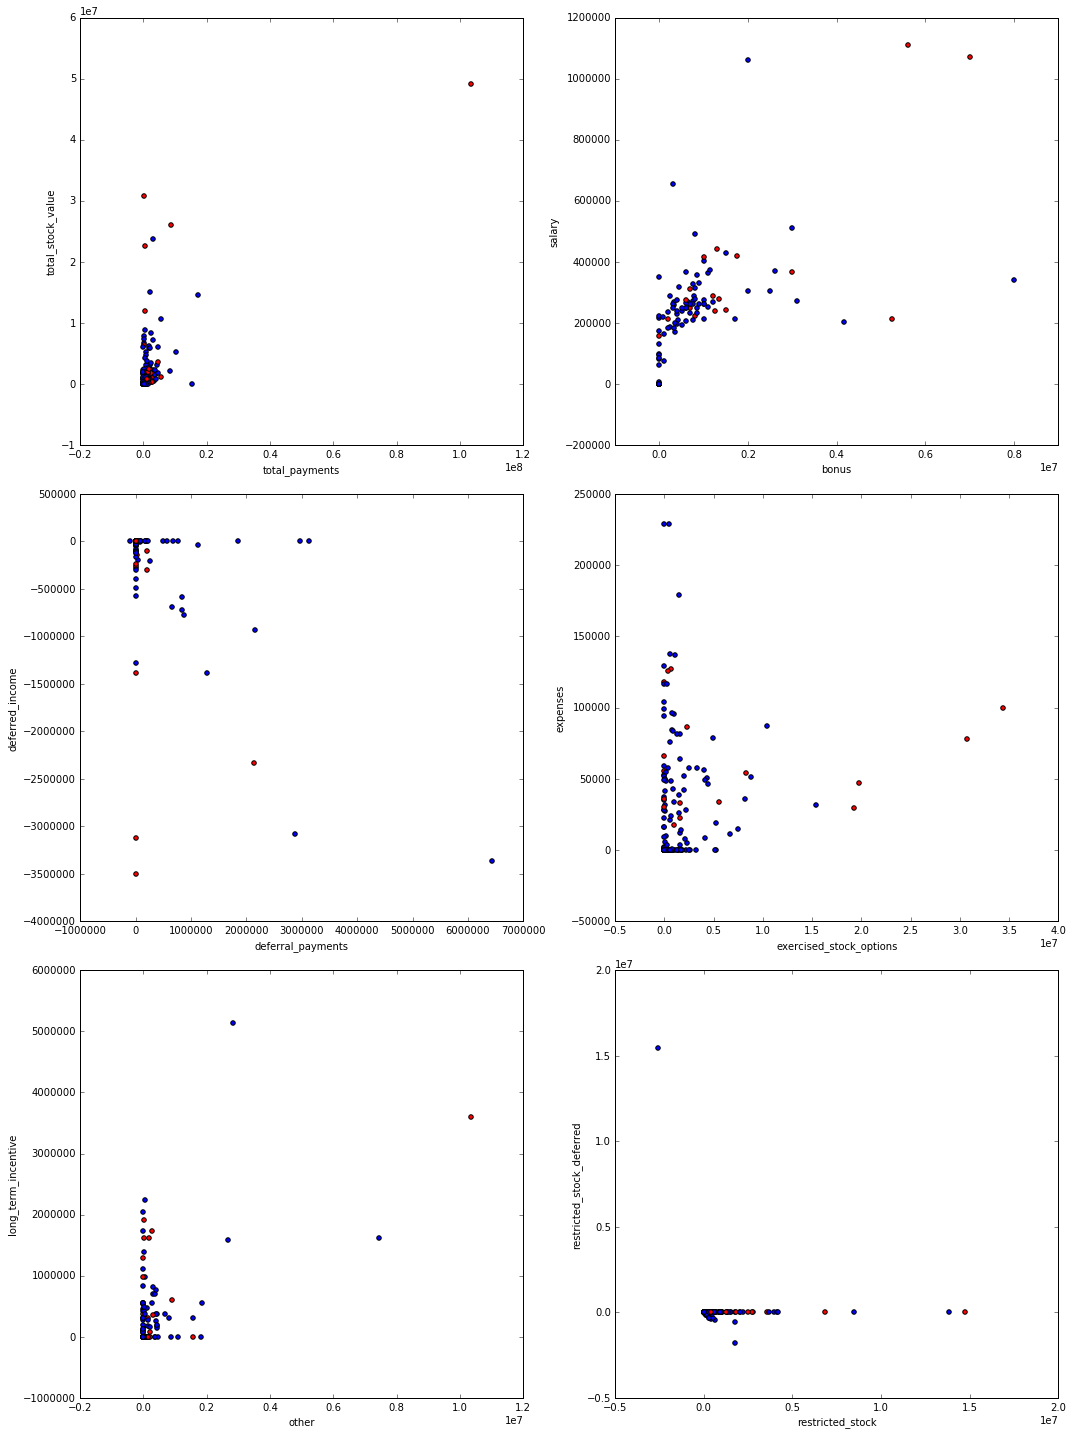

In [199]:
fig = pyplot.figure(figsize=(15, 20))

ax1 = fig.add_subplot(321)
scatteroutliers('total_payments', 'total_stock_value')

ax2 = fig.add_subplot(322)
scatteroutliers('bonus', 'salary') 

ax3 = fig.add_subplot(323)
scatteroutliers('deferral_payments','deferred_income')

ax4 = fig.add_subplot(324)
scatteroutliers('exercised_stock_options','expenses')

ax5 = fig.add_subplot(325)
scatteroutliers('other','long_term_incentive')

ax6 = fig.add_subplot(326)
scatteroutliers('restricted_stock','restricted_stock_deferred')

pyplot.tight_layout()

There is one financial feature left to look at, the feature with the fewest datapoints- the loan advances feature, which I will plot against POI.

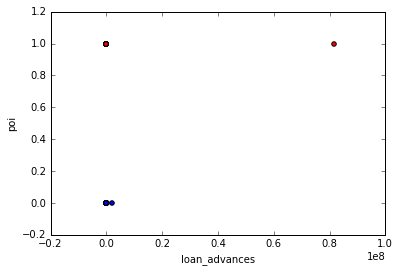

In [107]:
scatteroutliers('loan_advances', 'poi').show()

From the above charts, any outliers relating to POI's I will accept as being correct, since their financial compensation is likely to be disproportionally greater than others. However there are a few non POI outliers that stand out.

Notable outliers were found in the deferral payments and restricted stock deferred features.

Taking a look at these exact entries more closely gives the following data:

In [200]:
for key, value in data_dict.items():
    if value['deferral_payments'] > 6000000 and value['deferral_payments'] != 'NaN':
        print df.loc[key]

bonus                              2e+06
deferral_payments            6.42699e+06
deferred_income             -3.36701e+06
director_fees                        NaN
email_address                        NaN
exercised_stock_options      1.04335e+07
expenses                           86987
from_messages                         21
from_poi_to_this_person              242
from_this_person_to_poi                6
loan_advances                      2e+06
long_term_incentive          1.61701e+06
other                        7.42762e+06
poi                                False
restricted_stock             4.18867e+06
restricted_stock_deferred            NaN
salary                       1.06093e+06
shared_receipt_with_poi             2979
to_messages                         3275
total_payments               1.72525e+07
total_stock_value            1.46222e+07
Name: FREVERT MARK A, dtype: object


In [201]:
for key, value in data_dict.items():
    if value['restricted_stock_deferred'] > 15000000 and value['restricted_stock_deferred'] != 'NaN':
        print df.loc[key]

bonus                                NaN
deferral_payments                    NaN
deferred_income                      NaN
director_fees                     137864
email_address                        NaN
exercised_stock_options      2.60449e+06
expenses                             NaN
from_messages                         29
from_poi_to_this_person                0
from_this_person_to_poi                1
loan_advances                        NaN
long_term_incentive                  NaN
other                             137864
poi                                False
restricted_stock            -2.60449e+06
restricted_stock_deferred    1.54563e+07
salary                               NaN
shared_receipt_with_poi              463
to_messages                          523
total_payments               1.54563e+07
total_stock_value                    NaN
Name: BHATNAGAR SANJAY, dtype: object


Comparing the above to the PDF of the raw data, the information for Mark Frevert looks to be correct however the data for Sanjay Bhatnagar is incorrect. It looks as though this individual's figures had been shifted to the left by one column causing the total payments, and stock information to also be incorrect. I will therefore update the information and reload the information into a dataframe:

In [202]:
data_dict['BHATNAGAR SANJAY']['other'] = 'NaN'
data_dict['BHATNAGAR SANJAY']['expenses'] = 137864
data_dict['BHATNAGAR SANJAY']['director_fees'] = 'NaN'
data_dict['BHATNAGAR SANJAY']['total_payments'] = 137864
data_dict['BHATNAGAR SANJAY']['exercised_stock_options'] = 15456290
data_dict['BHATNAGAR SANJAY']['restricted_stock'] = 2604490
data_dict['BHATNAGAR SANJAY']['restricted_stock_deferred'] = -2604490
data_dict['BHATNAGAR SANJAY']['total_stock_value'] = 15456290

df = dataframing(data_dict)

Checking that the information has been correctly updated:

In [203]:
df.loc['BHATNAGAR SANJAY']

bonus                                NaN
deferral_payments                    NaN
deferred_income                      NaN
director_fees                        NaN
email_address                        NaN
exercised_stock_options      1.54563e+07
expenses                          137864
from_messages                         29
from_poi_to_this_person                0
from_this_person_to_poi                1
loan_advances                        NaN
long_term_incentive                  NaN
other                                NaN
poi                                False
restricted_stock             2.60449e+06
restricted_stock_deferred   -2.60449e+06
salary                               NaN
shared_receipt_with_poi              463
to_messages                          523
total_payments                    137864
total_stock_value            1.54563e+07
Name: BHATNAGAR SANJAY, dtype: object

This now looks to be correct. I'll now take a closer look at the features I will be using in the algorithm.

## New Features

A feature I think may be helpful in identifying a person of interest related to email information. If an individual has a high number of emails to/from a POI then perhaps this person is also a POI?

Looking at these numbers in proportion to the total number of emails sent and recieved may also provide some interesting information. 

I am going to create three new features relating to emails:
1. Ratio of emails sent from a POI to this person
2. Ratio of emails sent to a POI from this person
3. The aggregate of the above.


In [204]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

for name, item in my_dataset.items():
    my_dataset[name]['poi_email_pct'] = 0
    my_dataset[name]['from_poi_pct'] = 0
    my_dataset[name]['to_poi_pct'] = 0
    total_messages = item['from_messages'] + item['to_messages']
    if total_messages != 0 and item['from_poi_to_this_person'] != 'NaN' and item['from_this_person_to_poi'] != 'NaN':
        my_dataset[name]['poi_email_pct'] = ((float(item['from_poi_to_this_person'])+
                                              float(item['from_this_person_to_poi']))/
                                         (float(total_messages)))
        if item['from_messages'] != 0:
            my_dataset[name]['from_poi_pct'] = (float(item['from_poi_to_this_person'])/
                                         float(item['to_messages']))
        if item['to_messages'] != 0:
            my_dataset[name]['to_poi_pct'] = (float(item['from_this_person_to_poi'])/
                                         float(item['from_messages']))

In [205]:
df = dataframing(my_dataset)
print 'Aggregated Summary:'
print df['poi_email_pct'].describe()
print 'Emails From POI Summary:'
print df['from_poi_pct'].describe()
print 'Emails To POI Summary:'
print df['to_poi_pct'].describe()

Aggregated Summary:
count    144.000000
mean       0.028493
std        0.042827
min        0.000000
25%        0.000000
50%        0.008772
75%        0.043337
max        0.224352
Name: poi_email_pct, dtype: float64
Emails From POI Summary:
count    144.000000
mean       0.022672
std        0.036417
min        0.000000
25%        0.000000
50%        0.004952
75%        0.029918
max        0.217341
Name: from_poi_pct, dtype: float64
Emails To POI Summary:
count    144.000000
mean       0.109922
std        0.185935
min        0.000000
25%        0.000000
50%        0.000000
75%        0.198827
max        1.000000
Name: to_poi_pct, dtype: float64


## The Usage of Evaluation Metrics

Throughout the testing portion of the project I will be evaluating the different models with a focus on Precision, Recall and F1 scores using the test_classifier function from tester.py.

The accuracy score will also be given, however I will not focus too much on this statistic. The accuracy score is the ratio of correct predictions to total number of datapoints, however this does not make a distinction between the different classes. Also, in this case since the dataset is unbalanced (not many POIs included), so the classifier could reach high accuracy values just flagging every person as non-POI.

Precision is calculated using the following equation:

true positives / (true positives + false positives)

This is a measure of exactness, and calculates the percentage of correct positive classifications from the dataset. In the context of this project, it will tell us the percentage of POI's our model has correctly identified from the total number it has identified as POI.

Recall on the other hand looks at the completeness of your predictions, the percentage of true positives based on the total number of positive class values in the data and is defined by the following equation:

true positives/(true positives+ false negatives)

In the context of this project it will tell us the percentage of POI's identified based on the total number of POI's in the dataset.

Finally I will also look at the F1 score, given by the following equation:
2x((precision x recall)/(precision + recall))

This is the harmonic mean between the two scores.



## Feature Selection

I am now ready to select features I will be using in my chosen algorithm. 

I could potentially remove loan advances from the features list since  as discovered earlier, there are very few data points with this feature therefore it may not provide enough information.

I will use a decision tree classifier to try and identify the importance of the different features and test their effectiveness.

In [206]:
#data_check = featureFormat(my_dataset, features_list)

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

clf = DecisionTreeClassifier()



I'll start by first testing the complete features list (without the new features):

In [207]:
test_classifier(clf, my_dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
	Accuracy: 0.80013	Precision: 0.23344	Recall: 0.21850	F1: 0.22572	F2: 0.22133
	Total predictions: 15000	True positives:  437	False positives: 1435	False negatives: 1563	True negatives: 11565



The results show an accuracy rate of 0.8, and F1 score of 0.23 which I will use as a base, that I will attempt to improve upon. 

Next I will examine the effect of removing loan_advances from the features list:

In [155]:
features_list_no_loan = ['poi',
                'bonus',
                'deferral_payments',
                'deferred_income',
                'director_fees',
                'exercised_stock_options',
                'expenses',
                'from_messages',
                'from_poi_to_this_person',
                'from_this_person_to_poi',
                'long_term_incentive',
                'other',
                'restricted_stock',
                'restricted_stock_deferred',
                'salary',
                'shared_receipt_with_poi',
                'to_messages',
                'total_payments',
                'total_stock_value'
               ]
test_classifier(clf, my_dataset, features_list_no_loan)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
	Accuracy: 0.80047	Precision: 0.22972	Recall: 0.21100	F1: 0.21996	F2: 0.21450
	Total predictions: 15000	True positives:  422	False positives: 1415	False negatives: 1578	True negatives: 11585



This slightly worsened the scores. Adding the newly created feature, 'poi_email_pct' to the list gives the following results.

In [156]:
new_features_list = ['poi',
                'bonus',
                'deferral_payments',
                'deferred_income',
                'director_fees',
                'exercised_stock_options',
                'expenses',
                'from_messages',
                'from_poi_to_this_person',
                'from_this_person_to_poi',
                'loan_advances',
                'long_term_incentive',
                'other',
                'restricted_stock',
                'restricted_stock_deferred',
                'salary',
                'shared_receipt_with_poi',
                'to_messages',
                'total_payments',
                'total_stock_value',
                'poi_email_pct'
               ]
test_classifier(clf, my_dataset, new_features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
	Accuracy: 0.80193	Precision: 0.24299	Recall: 0.22950	F1: 0.23605	F2: 0.23208
	Total predictions: 15000	True positives:  459	False positives: 1430	False negatives: 1541	True negatives: 11570



Adding the aggregated 'poi_email_pct' feature to the classifier has improved the scores, next I will add the 'from_poi_pct' and 'to_poi_pct' features to the list which excludes the loan_advances feature to check for improvements in the scores:

In [163]:
to_from_features_list = ['poi',
                'bonus',
                'deferral_payments',
                'deferred_income',
                'director_fees',
                'exercised_stock_options',
                'expenses',
                'from_messages',
                'from_poi_to_this_person',
                'from_this_person_to_poi',
                'long_term_incentive',
                'other',
                'restricted_stock',
                'restricted_stock_deferred',
                'salary',
                'shared_receipt_with_poi',
                'to_messages',
                'total_payments',
                'total_stock_value',
                'from_poi_pct',
                'to_poi_pct'  
               ]
test_classifier(clf, my_dataset, to_from_features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
	Accuracy: 0.81300	Precision: 0.30104	Recall: 0.30450	F1: 0.30276	F2: 0.30380
	Total predictions: 15000	True positives:  609	False positives: 1414	False negatives: 1391	True negatives: 11586



Adding the 'from_poi_pct' and 'to_poi_pct' features seperately instead of the aggregated percentage has returned markedly improved results. 

Adding the loan advances feature back into this list yields the following scores:

In [169]:
final_features_list = ['poi',
                'bonus',
                'deferral_payments',
                'deferred_income',
                'director_fees',
                'exercised_stock_options',
                'expenses',
                'from_messages',
                'from_poi_to_this_person',
                'from_this_person_to_poi',
                'loan_advances',
                'long_term_incentive',
                'other',
                'restricted_stock',
                'restricted_stock_deferred',
                'salary',
                'shared_receipt_with_poi',
                'to_messages',
                'total_payments',
                'total_stock_value',
                'from_poi_pct',
                'to_poi_pct'
               ]
test_classifier(clf, my_dataset, final_features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
	Accuracy: 0.81340	Precision: 0.29711	Recall: 0.29250	F1: 0.29478	F2: 0.29341
	Total predictions: 15000	True positives:  585	False positives: 1384	False negatives: 1415	True negatives: 11616



Adding loan_advances back into the list has actually worsened the scores. Since the best scores involve the list which includes two of the new features, to_poi_pct and from_poi_pct and excludes loan_advances, I'll use this list.

Next I will take a look at the features in order of importance.

In [170]:
index = 1


for importance in clf.feature_importances_:
    if index < len(to_from_features_list):
        print to_from_features_list[index], importance
        index += 1


bonus 0.0
deferral_payments 0.0
deferred_income 0.0
director_fees 0.0
exercised_stock_options 0.333661385904
expenses 0.0
from_messages 0.0
from_poi_to_this_person 0.0170077433628
from_this_person_to_poi 0.0
long_term_incentive 0.0
other 0.0
restricted_stock 0.124537409493
restricted_stock_deferred 0.083283852811
salary 0.0
shared_receipt_with_poi 0.0
to_messages 0.247721151492
total_payments 0.0
total_stock_value 0.0
from_poi_pct 0.0662531605563
to_poi_pct 0.0


The most important feature appears to be exercised stock options and of the two new features, the 'from_poi_pct' has the most importance.

So far I haven't needed to scale any features, since this does not affect the results of a decision tree classifier.


## Selecting a Classifier

The two classifiers that I will be testing are:
1. Decision Tree Classifier
2. Support Vector Machine SVC classifier

I will be testing the results using each classifier, and then additionally I will use Ada Boost to try and further enhance the results.


### Scaling Features

So far the decision tree classifier has given us an F1, precision and recall scores of 0.3. I will try using the SVC classifier to try and improve on these scores. Since the data involves a number of different units of measurement, namely number of shares, number of emails, and monetary units, the SVC classifier requires me to scale the data as this may affect the results of the chosen algorithm.

I will be using the MinMax Scaler for this task.

The two steps outlined above can be combined into a pipeline for testing.

In [171]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.svm import SVC
#clf = SVC(kernel="rbf")

svc_clf = Pipeline([('scale', MinMaxScaler()),('classify', SVC(C=1000,kernel="rbf"))])

test_classifier(svc_clf, my_dataset, to_from_features_list)

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classify', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])
	Accuracy: 0.83800	Precision: 0.26374	Recall: 0.12000	F1: 0.16495	F2: 0.13468
	Total predictions: 15000	True positives:  240	False positives:  670	False negatives: 1760	True negatives: 12330



Using the SVC classifier has not improved the scores. 

However in the next step I will tune both the decision tree algorithm and the SVC algorithm to try and further improve both sets of results. 


### Parameter Tuning and Validation

When testing the algorithm I will need to split the data into training and testing sets in order to validate the performance of the algorithm. This is known as validation. The split between training and testing needs to be carried out in a way that there is enough data for the algorithm to train on, but also enough for it to test it. I will be using StratifiedShuffleSplit when evaluating the algorithms, as suggested by the notes below, due to the small size of the dataset. StratifiedShuffleSplit is a cross validation iterator used to split the data into train/test sets. This method of validation randomly chooses training and test sets multiple times and averages the results over all of the tests. 

With the data being unbalanced, ie more non-POIs than POIs, StratifidShuffleSplit also ensures the ratio of non-POI:POI is the same in the training and test sets as it was in the larger data set.

The chosen algorithms have so far used default parameters in the calculations, however, these parameters have not yet been tuned. Tuning an algorithm optimises the accuracy, if this is not done well, predictions will not be as accurate as they could be. Tuning the algorithms using GridSearchCV will identify the optimal parameters for each algorithm in order to further improve the results.



In [172]:
### Extract features and labels from dataset for local testing


### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html



# Example starting point. Try investigating other evaluation techniques!
#from sklearn.cross_validation import train_test_split
#features_train, features_test, labels_train, labels_test = \
    #train_test_split(features, labels, test_size=0.3, random_state=42)
    
from sklearn.cross_validation import StratifiedShuffleSplit
data = featureFormat(my_dataset, to_from_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
folds = 1000
cv = StratifiedShuffleSplit(
     labels, folds, random_state=random)    

I will start by tuning the decision tree classifier.

In [178]:
from sklearn.grid_search import GridSearchCV

parameters = {'criterion':('gini', 'entropy'), 'max_features':('auto','sqrt','log2',None)}
tree = DecisionTreeClassifier()
decision_tree_clf = GridSearchCV(tree, parameters, cv=cv)
decision_tree_clf.fit(features, labels)

print 'The best parameters are:', decision_tree_clf.best_params_
print 'The score of this combination of parameters was:', decision_tree_clf.best_score_


The best parameters are: {'max_features': 'sqrt', 'criterion': 'entropy'}
The score of this combination of parameters was: 0.8232


Testing the tuned classifier gives the following results:

In [185]:
decision_tree_classifier = DecisionTreeClassifier(criterion = 'entropy', max_features = 'sqrt')

test_classifier(decision_tree_classifier, my_dataset, to_from_features_list)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
	Accuracy: 0.82267	Precision: 0.32704	Recall: 0.31200	F1: 0.31934	F2: 0.31490
	Total predictions: 15000	True positives:  624	False positives: 1284	False negatives: 1376	True negatives: 11716



This has improved the results somewhat, with precision and recall moving closer to 0.33.

Tuning the SVC classifier gives the following results:

In [186]:
#from sklearn.svm import SVC

parameters = {
            'classify__kernel':('rbf','linear', 'poly'),
            'classify__C': [10,100,1000],
            'classify__gamma': [0.001, 0.01, 0.1]
              }

svc_pipeline = Pipeline([('scale', MinMaxScaler()),('classify', SVC())])

grid_svc_clf = GridSearchCV(svc_pipeline, parameters, cv=cv)
grid_svc_clf.fit(features, labels)

print 'The best parameters are:', grid_svc_clf.best_params_
print 'The score of this combination of parameters was:', grid_svc_clf.best_score_


The best parameters are: {'classify__C': 100, 'classify__gamma': 0.01, 'classify__kernel': 'rbf'}
The score of this combination of parameters was: 0.876266666667


In [187]:
svc_clf = Pipeline([('scale', MinMaxScaler()),('classify', SVC(C=100,kernel="rbf", gamma=0.01))])

test_classifier(svc_clf, my_dataset, to_from_features_list)

Pipeline(steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classify', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.01,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])
	Accuracy: 0.87400	Precision: 0.67405	Recall: 0.10650	F1: 0.18394	F2: 0.12807
	Total predictions: 15000	True positives:  213	False positives:  103	False negatives: 1787	True negatives: 12897



So far the best scores were from using the decision tree classifier using parameters 'sqrt' and 'entropy' for the max_features and criterion parameters respectively. One additional tool we can use is the Ada Boost classifier. This classifier can be used alongside others to improve performance by focussing on the more difficult to classify datapoints.

The Ada Boost classifier can also be tuned to return the best parameters.

### Ada Boost Classifier


In [132]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {'n_estimators': [10, 50, 80, 100], 'algorithm':('SAMME', 'SAMME.R'),
              'learning_rate':[0.1, 0.5, 1, 2]}
ada_boost = AdaBoostClassifier(DecisionTreeClassifier(criterion = 'gini', max_features = 'auto'))
ada_boost_clf = GridSearchCV(ada_boost, parameters, cv=cv)
ada_boost_clf.fit(features, labels)

print 'The best parameters are:', ada_boost_clf.best_params_
print 'The score of this combination of parameters was:', ada_boost_clf.best_score_


The best parameters are: {'n_estimators': 10, 'learning_rate': 2, 'algorithm': 'SAMME.R'}
The score of this combination of parameters was: 0.824


In [133]:
ada_boost_classifier = AdaBoostClassifier(DecisionTreeClassifier(criterion = 'gini', max_features = 'auto'),
                                         n_estimators=10, algorithm='SAMME.R', learning_rate=2)

test_classifier(ada_boost_classifier, my_dataset, to_from_features_list)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
          learning_rate=2, n_estimators=10, random_state=None)
	Accuracy: 0.81807	Precision: 0.31240	Recall: 0.30350	F1: 0.30789	F2: 0.30524
	Total predictions: 15000	True positives:  607	False positives: 1336	False negatives: 1393	True negatives: 11664



The Ada Boost classifier worsened the results and therefore won't be used in the final algorithm.


## The Final Algorithm

After testing the decision tree classifier, and the support vector machine SVC classifier, tuning each algorithm to obtain the best parameters and trying to further improve the results using the Ada Boost classifier I have found the best results with the following algorithm and parameters:

Algorithm: Decision Tree Classifier

Criterion: Entropy

Max_Features: Sqrt

This yields the following scores:

Precision = 0.327

Recall = 0.312

F1 = 0.319

Therefore, the algorithm is able to correctly identify a POI 32.7% of the time, and is able to identify 31.2% of POI's from the total number of POI's. There is still significant room for improvement with these scores, and perhaps by looking at the emails themselves and analysing the language used, implementing bag of words we could more accurately identify a POI.






